In [1]:
import shutil

import matplotlib.pyplot as plt
import pandas as pd

import evalml

from functions import *

pd.set_option('display.float_format', '{:.6f}'.format)

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
2023-11-01 16:16:24.181600: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-01 16:16:24.887454: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Data

In [2]:
min_non_zero_pct = 0.5
window_size = 3
sequence_length = 10
number_test_sequences = 3

df = load_and_merge()
df = remove_underpopulated_taxa(df, min_non_zero_pct)
df = standard_rolling_average(df, window_size)
df = feature_wise_scaling(df)

In [3]:
df

,659361,364179,3439402,181155,302746,4473763,175535,3887769,585227,189384,...,3304236,584137,193233,4334711,196664,583117,354850,subject_id,sampling_day,ind_time
E000823.4.0,0.000000,0.000160,0.288889,0.000000,0.000000,0.242718,0.010256,0.190476,0.000000,0.100671,...,0.029412,0.000000,0.040201,0.455696,0.059699,0.010154,0.064039,E000823,0.072046,0.072046
E000823.5.0,0.000000,0.000160,0.200000,0.000000,0.000000,0.199029,0.007692,0.119048,0.000000,0.120805,...,0.117647,0.000000,0.035804,0.398734,0.054162,0.010779,0.029557,E000823,0.100865,0.100865
E000823.5.7,0.000000,0.000180,0.200000,0.003724,0.000000,0.228155,0.007692,0.023810,0.000000,0.053691,...,0.117647,0.000000,0.034338,0.518987,0.060045,0.009685,0.019704,E000823,0.121037,0.121037
E000823.6.7,0.065636,0.000160,0.088889,0.016139,0.000000,0.121359,0.002564,0.023810,0.000000,0.080537,...,0.205882,0.000085,0.021566,0.386076,0.035127,0.006092,0.000000,E000823,0.149856,0.149856
E000823.8.5,0.065636,0.000220,0.177778,0.017381,0.000000,0.490291,0.020513,0.071429,0.000000,0.053691,...,0.176471,0.000085,0.050251,0.386076,0.061602,0.037334,0.000000,E000823,0.201729,0.201729
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
E014086.30.4,0.060355,0.080890,0.288889,0.007449,0.044379,0.111650,0.025641,0.476190,0.479017,0.503356,...,0.470588,0.055292,0.091290,0.253165,0.127531,0.423113,0.068966,E014086,0.832853,0.832853
E014086.32.4,0.060355,0.120524,0.622222,0.010552,0.077663,0.194175,0.071795,0.404762,0.880928,0.711409,...,0.441176,0.071990,0.142169,0.341772,0.345042,0.622876,0.285714,E014086,0.890490,0.890490
E014086.33.5,0.051679,0.141802,1.000000,0.011173,0.161243,0.436893,0.074359,0.619048,0.849198,0.906040,...,0.264706,0.057024,0.213358,0.373418,0.537809,0.756436,0.507389,E014086,0.922190,0.922190
E014086.34.4,0.021124,0.127490,0.977778,0.004345,0.160503,0.572816,0.071795,0.571429,0.761174,0.899329,...,0.294118,0.037543,0.241625,0.316456,0.631597,0.749125,0.610837,E014086,0.948127,0.948127


## Features and targets

In [4]:
train_feats, train_targets, val_feats, val_targets, test_feats, test_targets, test_subjects = xgboost_flat_feats_and_targets(df, n_test_seq=number_test_sequences, seq_length=sequence_length)

The test subjects are ['E000823' 'E013094' 'E006493']


In [5]:
train_feats, _, train_targets, _ = evalml.preprocessing.split_data(train_feats, train_targets, problem_type="regression", test_size=0.001)

In [6]:
train_feats

,0,1,2,3,4,5,6,7,8,9,...,2230,2231,2232,2233,2234,2235,2236,2237,2238,2239
109,0.158431,0.164089,0.156545,0.091664,0.197661,0.172765,0.171633,0.003395,0.002641,0.002263,...,0.028818,0.028818,0.028818,0.031700,0.025937,0.028818,0.023055,0.031700,0.066282,0.023055
74,0.013580,0.013580,0.054319,0.042248,0.042248,0.000000,0.000377,0.000377,0.000377,0.000377,...,0.017291,0.025937,0.031700,0.028818,0.028818,0.028818,0.023055,0.028818,0.028818,0.028818
110,0.524708,0.161071,0.284798,0.252735,0.158431,0.039230,0.124859,0.145605,0.136929,0.203320,...,0.028818,0.025937,0.031700,0.025937,0.066282,0.017291,0.060519,0.034582,0.028818,0.031700
71,0.026405,0.027537,0.028291,0.003018,0.032818,0.067899,0.070162,0.152395,0.125613,0.122218,...,0.043228,0.031700,0.031700,0.023055,0.028818,0.037464,0.017291,0.023055,0.057637,0.037464
129,0.000000,0.000000,0.000000,0.000000,0.000000,0.001509,0.013580,0.013580,0.054319,0.042248,...,0.025937,0.031700,0.028818,0.054755,0.028818,0.037464,0.017291,0.025937,0.031700,0.028818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,0.208223,0.281780,0.169370,0.185213,0.032441,0.033572,0.023010,0.023387,0.010939,0.024142,...,0.054755,0.017291,0.031700,0.144092,0.063401,0.037464,0.017291,0.034582,0.025937,0.037464
192,0.000000,0.000754,0.000754,0.000754,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.037464,0.031700,0.040346,0.023055,0.080692,0.057637,0.051873,0.028818,0.123919,0.025937
117,0.000000,0.000000,0.000377,0.000377,0.000377,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.031700,0.031700,0.066282,0.017291,0.034582,0.034582,0.063401,0.031700,0.028818,0.011527
47,0.000000,0.000377,0.000377,0.000377,0.000000,0.068276,0.070162,0.070162,0.001886,0.000000,...,0.034582,0.017291,0.034582,0.025937,0.034582,0.048991,0.025937,0.063401,0.043228,0.031700


In order to properly train an XGBoost model we need a proper validation set

## The model

In [7]:
import xgboost as xgb
model = xgb.XGBRegressor(objective='reg:squarederror', 
                         n_estimators=10, 
                         max_leaves=100,
                         max_depth=100,  
                         n_jobs=50)

In [8]:
model.fit(train_feats, train_targets, eval_set=[(val_feats, val_targets)], verbose=True)

[0]	validation_0-rmse:0.14190
[1]	validation_0-rmse:0.12351
[2]	validation_0-rmse:0.11146
[3]	validation_0-rmse:0.10368
[4]	validation_0-rmse:0.09860
[5]	validation_0-rmse:0.09527
[6]	validation_0-rmse:0.09312
[7]	validation_0-rmse:0.09159
[8]	validation_0-rmse:0.09027
[9]	validation_0-rmse:0.08929


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=100, max_leaves=100,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=10, n_jobs=50,
             num_parallel_tree=None, random_state=None, ...)

## Validation

In [9]:
test_subjects

array(['E000823', 'E013094', 'E006493'], dtype=object)

In [10]:
target_subject_idx = 0
target_subject = test_subjects[target_subject_idx]

subject_feats = test_feats[target_subject]
subject_targets = test_targets[target_subject]

In [11]:
subject_feats, _, subject_targets, _ = evalml.preprocessing.split_data(subject_feats, subject_targets, problem_type="regression", test_size=0.001)

In [12]:
subject_targets

,659361,364179,3439402,181155,302746,4473763,175535,3887769,585227,189384,...,359650,130663,922761,3304236,584137,193233,4334711,196664,583117,354850
16,0.049793,0.000100,0.111111,0.000000,0.011095,0.121359,0.020513,0.023810,0.032071,0.154362,...,0.511468,0.053571,0.000613,0.117647,0.024678,0.049623,0.044304,0.054508,0.140465,0.059113
14,0.030177,0.000180,0.266667,0.000621,0.090237,0.121359,0.000000,0.261905,0.030706,0.134228,...,0.594037,0.089286,0.002427,0.029412,0.113197,0.013610,0.183544,0.040664,0.203637,0.024631
21,0.101094,0.000160,0.111111,0.002483,0.073225,0.048544,0.048718,0.333333,0.069601,0.255034,...,0.549312,0.035714,0.173334,0.470588,0.113367,0.095687,0.082278,0.066274,0.152681,0.064039
12,0.000000,0.000280,0.311111,0.000621,0.105769,0.116505,0.007692,0.476190,0.293415,0.241611,...,0.557339,0.107143,0.005067,0.176471,0.117144,0.015285,0.246835,0.043087,0.307361,0.054187
23,0.139570,0.000340,0.288889,0.000000,0.052515,0.029126,0.117949,0.309524,0.107131,0.127517,...,0.432339,0.062500,0.000373,0.264706,0.015648,0.144472,0.101266,0.097422,0.226506,0.118227
19,0.009430,0.000460,0.244444,0.004345,0.098373,0.053398,0.082051,0.285714,0.021153,0.255034,...,0.486239,0.000000,0.173334,0.411765,0.041008,0.137353,0.025316,0.155390,0.166552,0.059113
11,0.000000,0.000180,0.177778,0.000621,0.042160,0.048544,0.007692,0.285714,0.292050,0.194631,...,0.321101,0.062500,0.003814,0.147059,0.062733,0.011097,0.107595,0.024745,0.264090,0.167488
17,0.029046,0.000240,0.155556,0.001862,0.021450,0.111650,0.069231,0.095238,0.030365,0.174497,...,0.661697,0.044643,0.000107,0.117647,0.042342,0.139866,0.044304,0.142585,0.179361,0.059113
20,0.004527,0.000360,0.200000,0.002483,0.110947,0.048544,0.043590,0.309524,0.050836,0.315436,...,0.500000,0.000000,0.173414,0.470588,0.126800,0.065955,0.037975,0.080118,0.171957,0.068966
13,0.000000,0.000280,0.333333,0.000621,0.118343,0.126214,0.007692,0.500000,0.201296,0.214765,...,0.697248,0.107143,0.005574,0.117647,0.158407,0.016960,0.240506,0.045510,0.301300,0.049261


In [13]:
pred_df = pd.DataFrame(model.predict(subject_feats))
pred_df.columns = subject_targets.columns
pred_df

,659361,364179,3439402,181155,302746,4473763,175535,3887769,585227,189384,...,359650,130663,922761,3304236,584137,193233,4334711,196664,583117,354850
0,0.027881,0.003624,0.080154,0.008703,0.031761,0.068137,0.130140,0.207233,0.164282,0.092967,...,0.300369,0.069031,0.003819,0.091672,0.055782,0.061002,0.067462,0.072614,0.258151,0.080272
1,0.005542,0.003624,0.382733,0.007643,0.090356,0.225274,0.026670,0.308992,0.308701,0.209340,...,0.485421,0.113463,0.006415,0.075851,0.115310,0.020420,0.176262,0.064044,0.296800,0.066459
2,0.014741,0.003624,0.148806,0.006016,0.099809,0.078738,0.053186,0.303633,0.179204,0.288020,...,0.459392,0.041442,0.021967,0.477659,0.095194,0.076219,0.048183,0.113206,0.247587,0.105361
3,0.010160,0.003624,0.226059,0.008835,0.043842,0.072107,0.011442,0.359018,0.243572,0.137228,...,0.334210,0.137727,0.004457,0.113893,0.023624,0.014466,0.080567,0.073893,0.222653,0.217699
4,0.093662,0.003624,0.310122,0.006892,0.047753,0.118979,0.063488,0.232473,0.153785,0.262337,...,0.602429,0.064897,0.004367,0.267163,0.089095,0.172332,0.104796,0.205211,0.224744,0.069246
5,0.046606,0.007960,0.309740,0.010491,0.088552,0.192093,0.063958,0.121608,0.064348,0.140071,...,0.446707,0.048825,0.003819,0.099272,0.070530,0.161822,0.064422,0.134970,0.184285,0.059036
6,0.009428,0.003624,0.175435,0.005485,0.023226,0.013160,0.128186,0.098217,0.136322,0.117319,...,0.120854,0.129814,0.004560,0.217592,0.038742,0.052880,0.074963,0.079613,0.209801,0.233133
7,0.044319,0.003624,0.064820,0.010295,0.018524,0.165536,0.132136,0.214233,0.180297,0.121207,...,0.396738,0.056329,0.003819,0.176236,0.034354,0.196669,0.072711,0.063312,0.243932,0.083358
8,0.065934,0.003624,0.183949,0.009904,0.085238,0.053657,0.057507,0.224090,0.175568,0.214011,...,0.323884,0.033713,0.055224,0.363880,0.029868,0.104930,0.042448,0.164733,0.254740,0.098012
9,0.004463,0.003624,0.389040,0.007643,0.081323,0.211803,0.020206,0.350193,0.276334,0.131163,...,0.460063,0.117805,0.004457,0.182389,0.128269,0.018190,0.159948,0.065771,0.437453,0.127207


In [14]:
test_targets[target_subject]

,659361,364179,3439402,181155,302746,4473763,175535,3887769,585227,189384,...,359650,130663,922761,3304236,584137,193233,4334711,196664,583117,354850
10,0.000000,0.000060,0.155556,0.000621,0.025888,0.014563,0.000000,0.071429,0.144661,0.134228,...,0.072248,0.035714,0.004774,0.088235,0.019055,0.003559,0.037975,0.012459,0.144776,0.137931
11,0.000000,0.000180,0.177778,0.000621,0.042160,0.048544,0.007692,0.285714,0.292050,0.194631,...,0.321101,0.062500,0.003814,0.147059,0.062733,0.011097,0.107595,0.024745,0.264090,0.167488
12,0.000000,0.000280,0.311111,0.000621,0.105769,0.116505,0.007692,0.476190,0.293415,0.241611,...,0.557339,0.107143,0.005067,0.176471,0.117144,0.015285,0.246835,0.043087,0.307361,0.054187
13,0.000000,0.000280,0.333333,0.000621,0.118343,0.126214,0.007692,0.500000,0.201296,0.214765,...,0.697248,0.107143,0.005574,0.117647,0.158407,0.016960,0.240506,0.045510,0.301300,0.049261
14,0.030177,0.000180,0.266667,0.000621,0.090237,0.121359,0.000000,0.261905,0.030706,0.134228,...,0.594037,0.089286,0.002427,0.029412,0.113197,0.013610,0.183544,0.040664,0.203637,0.024631
15,0.030555,0.000080,0.088889,0.000000,0.022189,0.058252,0.002564,0.047619,0.041624,0.080537,...,0.403670,0.044643,0.001147,0.029412,0.064152,0.021566,0.044304,0.025437,0.151368,0.059113
16,0.049793,0.000100,0.111111,0.000000,0.011095,0.121359,0.020513,0.023810,0.032071,0.154362,...,0.511468,0.053571,0.000613,0.117647,0.024678,0.049623,0.044304,0.054508,0.140465,0.059113
17,0.029046,0.000240,0.155556,0.001862,0.021450,0.111650,0.069231,0.095238,0.030365,0.174497,...,0.661697,0.044643,0.000107,0.117647,0.042342,0.139866,0.044304,0.142585,0.179361,0.059113
18,0.028668,0.000540,0.311111,0.001862,0.104290,0.131068,0.100000,0.095238,0.028659,0.241611,...,0.761468,0.035714,0.000107,0.117647,0.046432,0.169179,0.044304,0.194151,0.223288,0.029557
19,0.009430,0.000460,0.244444,0.004345,0.098373,0.053398,0.082051,0.285714,0.021153,0.255034,...,0.486239,0.000000,0.173334,0.411765,0.041008,0.137353,0.025316,0.155390,0.166552,0.059113


In [15]:
def fetch_subject_y_true_and_y_pred(test_subjects, model, df, target_subject_idx, test_feats, test_targets):
    
    cols = df.columns
    cols = cols[~cols.isin(metadata_cols)]
    
    target_subject = test_subjects[target_subject_idx]

    test_subject_feats = np.asarray(test_feats[target_subject])
    test_subject_targets_df = test_targets[target_subject]
    
    test_subject_targets_df.columns = cols
    test_subject_y_pred = model.predict(test_subject_feats)
    
    test_subject_y_pred_df = pd.DataFrame(test_subject_y_pred)
    test_subject_y_pred_df.columns = cols
    test_subject_y_pred_df.index = test_subject_targets_df.index

    return test_subject_targets_df, test_subject_y_pred_df

In [16]:
subjects_error_dfs = []
for target_subject_idx in range(len(test_subjects)):
    
    test_subject_targets_df, test_subject_y_pred_df = fetch_subject_y_true_and_y_pred(test_subjects, model, df, target_subject_idx, test_feats, test_targets)

    errors_df = calculate_percentage_errors(test_subject_y_pred_df, test_subject_targets_df)
    subjects_error_dfs.append(errors_df)
    
errors_df = pd.concat(subjects_error_dfs)

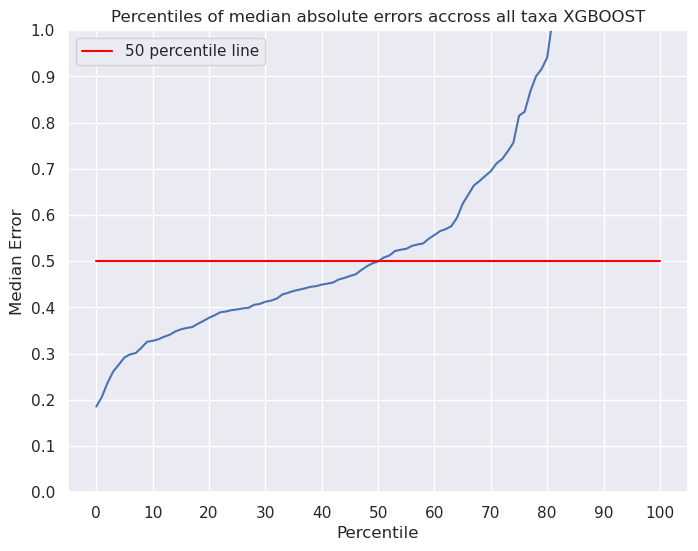

In [17]:
percentile_graph(errors_df, "accross all taxa XGBOOST", y_top_lim=1)

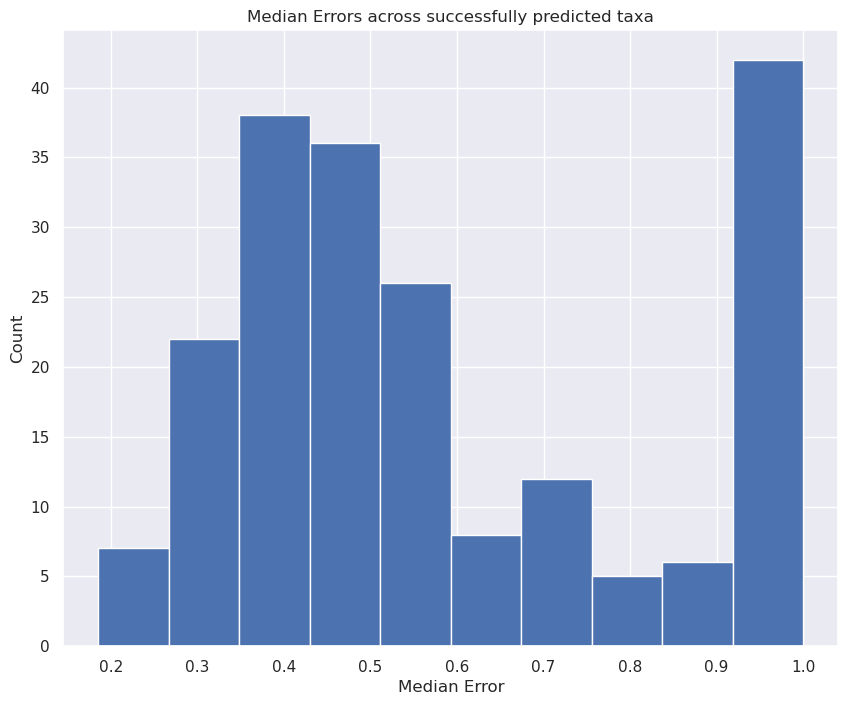

In [18]:
median_errors_plot(errors_df, clip=1)